# SHAREWave8 Dataset

This notebook forms part of the Appendices, provides supplementary materials that are essential for understanding my research, but would otherwise crowd the main body of my report. I used this notebook to present detailed data, methodologies, and analyses that support my research findings without disrupting the flow of the report's narrative. Specifically, this appendix/ notebook contain:

- Detailed data pre-processing steps, including steps for handling missing data, encoding, and normalization for the SHARE dataset, which is crucial for reproducibility but may be too granular for the main report.

- Visualizations and correlation analyses, providing comprehensive graphical representations and statistical analyses that offer deeper insights into the data. 

- Feature engineering details, elaborating on the selection and optimisation of features for model learning -underpinning the models' performance and interpretability.

- Hyper-parameter tuning and model evaluation metrics, with detailed tables and charts documenting the process of tuning machine learning models and their performance across various metrics.

- SHAP value analyses and bias mitigation strategies, offering in-depth discussions and visualizations related to model interpretability and fairness, critical for understanding the models' decision-making processes.

- Detailed code, with comments, for the relevant phases of project work.


In [ ]:
#%cd /content/drive/MyDrive/

In [ ]:
#!rm -rf /content/drive/*


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

# Path to the zip file
zip_file_path = '/content/drive/MyDrive/Share_dataset/sharew8_rel8-0-0_ALL_datasets_stata (1).zip'

# Destination folder where you want to unzip the contents
destination_folder = '/content/drive/MyDrive/Transfer/SHAREw8'

# Create the destination folder if it doesn't exist
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

In [3]:
import os
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from itertools import combinations
from joblib import Parallel, delayed
import glob
from functools import reduce
import geopandas.tools
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import joblib
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

In [4]:
# Specify the path to the dataset directory
directory_path = '/content/drive/MyDrive/Transfer/SHAREw8'
dataset = []

# List all .dta files in the directory
files = glob.glob(os.path.join(directory_path, '*.dta'))

def check_structure(file_path, sample_data):
    try:
        data = pd.read_stata(file_path)
        dataset.append(data)
        return data.info() == sample_data.info()
    except Exception as e:
        print(f"Error reading {os.path.basename(file_path)}: {e}")
        return False

# Read the first file to get its structure
sample_file = files[0]
sample_file_path = os.path.join(sample_file)
df0 = pd.read_stata(sample_file_path)

# Check the structure for all other files
all_have_same_structure = all(check_structure(os.path.join(file), df0) for file in files[1:])

# Display the result
print("All files have the same structure." if all_have_same_structure else "Files have different structures.")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46733 entries, 0 to 46732
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   mergeid    46733 non-null  object  
 1   hhid8      46733 non-null  object  
 2   mergeidp8  46733 non-null  object  
 3   coupleid8  46733 non-null  object  
 4   country    46733 non-null  category
 5   language   46733 non-null  category
 6   fam_resp   46733 non-null  category
 7   fin_resp   46733 non-null  category
 8   hou_resp   46733 non-null  category
 9   mn005_     46731 non-null  category
 10  mn024_     46731 non-null  category
 11  mn026_     46731 non-null  category
 12  mn029_     46731 non-null  category
 13  mn032_     46731 non-null  category
 14  mn038_     46731 non-null  category
 15  mn040_     46731 non-null  category
 16  mn041_     46731 non-null  category
 17  mn101_     46731 non-null  category
 18  mn104_     46731 non-null  category
dtypes: category(15), object(4

In [5]:
# Filter DataFrames that do not have 'mergeid'
filtered_dataset = [df for df in dataset if 'mergeid' in df.columns]


In [6]:
# Perform the outer merge on 'mergeid'
df = reduce(lambda left, right: pd.merge(left, right, on='mergeid', how='outer', suffixes=('', '_other')), filtered_dataset)
df.describe()

,exrate,hh011v1,hh011v2,hh011v3,hh017v1,hh017v2,hh017v3,ex009age,exrate_other,ho008v1,...,as051v3,as055v1,as055v2,as055v3,as070v1,as070v2,as070v3,as642v1,as642v2,as642v3
count,46733.000000,230.000000,230.000000,230.000000,5176.000000,5176.000000,5176.000000,46727.000000,46733.000000,304.000000,...,2428.000000,722.000000,722.000000,722.000000,8078.000000,8078.000000,8078.000000,721.000000,721.000000,7.210000e+02
mean,9.616412,350.099670,877.202407,2098.454187,1200.907304,1871.841099,2821.140987,83.765917,9.616412,71.723557,...,9031.580523,1875.192212,5818.864233,16712.445439,52.039059,173.380005,681.994503,2892.972900,38047.469928,1.693958e+05
std,44.969819,362.353302,654.822355,1295.539580,828.539621,1317.266994,2068.620962,8.268687,44.969819,31.120039,...,5856.658321,1655.153624,4088.836770,11673.590379,43.759945,128.414185,560.329537,5169.575684,42621.473864,2.037522e+05
min,1.000000,51.129971,200.000000,460.169752,153.389917,289.357832,413.368332,75.000000,1.000000,20.000000,...,2045.198896,255.649862,818.079558,2556.498619,1.890002,3.780004,30.000000,20.668417,664.689641,4.090398e+03
25%,1.000000,190.752335,500.000000,1000.000000,453.600454,756.000756,1000.000000,75.000000,1.000000,50.000000,...,5000.000000,600.000000,2000.000000,8000.000000,10.000000,100.000000,270.000000,100.000000,9000.000000,7.560008e+04
50%,1.000000,200.000000,795.924865,2000.000000,1000.000000,1500.000000,2000.000000,85.000000,1.000000,67.076279,...,6000.000000,1500.000000,4000.000000,13000.000000,50.000000,200.000000,600.000000,953.761658,20378.012125,1.000000e+05
75%,4.443000,331.635345,1000.000000,2700.000000,1526.018617,2500.000000,3500.000000,90.000000,4.443000,100.000000,...,13000.000000,2700.000000,9341.429239,27000.000000,93.414291,238.440414,953.761636,3756.271729,50000.000000,1.868286e+05
max,351.250000,1868.285889,3736.571695,7473.143391,3000.000000,4670.714619,7473.143391,110.000000,351.250000,150.000000,...,25000.000000,6707.627914,14000.000000,51377.860813,254.725159,764.175476,2547.251516,25000.000000,200000.000000,1.200000e+06


In [7]:
df.head()

,mergeid,hhid8,mergeidp8,coupleid8,country,language,fam_resp,fin_resp,hou_resp,mn005_,...,ch526_11,ch526_12,ch526_13,ch526_14,ch526_15,ch526_16,ch526_17,ch526_18,ch526_19,ch526_20
0,AT-001215-01,AT-001215-A,,,Austria,German (at),Family respondent,Financial respondent,Household respondent,Single,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT-001492-01,AT-001492-A,AT-001492-02,AT-001492-01-02,Austria,German (at),Family respondent,Financial respondent,Household respondent,"Couple, first respondent",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT-001492-02,AT-001492-A,AT-001492-01,AT-001492-01-02,Austria,German (at),Not family respondent,Not financial respondent,Not household respondent,"Couple, second respondent",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT-001881-01,AT-001881-A,,,Austria,German (at),Family respondent,Financial respondent,Household respondent,Single,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT-001881-02,AT-001881-B,,,Austria,German (at),Family respondent,Financial respondent,Household respondent,Single,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Extract Required Features

In [8]:
# Get all columns that start with prefixes "hc", "ep", ph", "mh", "ft", and "cf"
selected_columns = df.filter(regex='^(hc|ft|ep|ph|mh|cf|deceased)', axis=1)

# Store the names of selected columns
selected_column_names = ["age_int", "gender"] + selected_columns.columns.tolist()

# Combine selected columns with their names
data = df[selected_column_names]

data.head()

,age_int,gender,mh002_,mh003_,mh004_,mh005_,mh006_,mh007_,mh008_,mh009_,...,cf849_,cf850_,cf851_,cf852_,cf853_,cf855d1,cf855d2,cf855d3,cf855d4,cf855d5
0,80,Female,No,Any hopes mentioned,No such feelings,No such feelings,NaN,Trouble with sleep or recent change in pattern,No mention of loss of interest,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68,Female,No,Any hopes mentioned,No such feelings,No such feelings,NaN,No trouble sleeping,No mention of loss of interest,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,68,Male,Yes,Any hopes mentioned,No such feelings,No such feelings,NaN,No trouble sleeping,No mention of loss of interest,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,89,Female,Don't know,Don't know,Don't know,Don't know,NaN,Don't know,Don't know,NaN,...,Does not apply; R doesnât do activity,No,No,No,Don't know,Selected,Not selected,Not selected,Not selected,Not selected
4,95,Male,No,No hopes mentioned,No such feelings,No such feelings,NaN,No trouble sleeping,No mention of loss of interest,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data['age_int'].value_counts()

Not applicable    49202
71                 1872
69                 1863
67                 1845
65                 1816
                  ...  
36                    1
31                    1
38                    1
102                   1
34                    1
Name: age_int, Length: 72, dtype: int64

In [10]:
sur_analysis_df=data

In [11]:
A=data[['age_int','deceased']]
A[A['age_int']!='Not applicable'].value_counts()

age_int  deceased
71       Alive       1872
69       Alive       1863
67       Alive       1845
65       Alive       1816
68       Alive       1803
                     ... 
38       Alive          1
36       Alive          1
34       Alive          1
102      Alive          1
31       Alive          1
Length: 71, dtype: int64

In [12]:
sur_analysis_df['deceased'].value_counts()


Alive       90986
Deceased     4949
Name: deceased, dtype: int64

<ipython-input-13-68500a3bb83b>:6: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


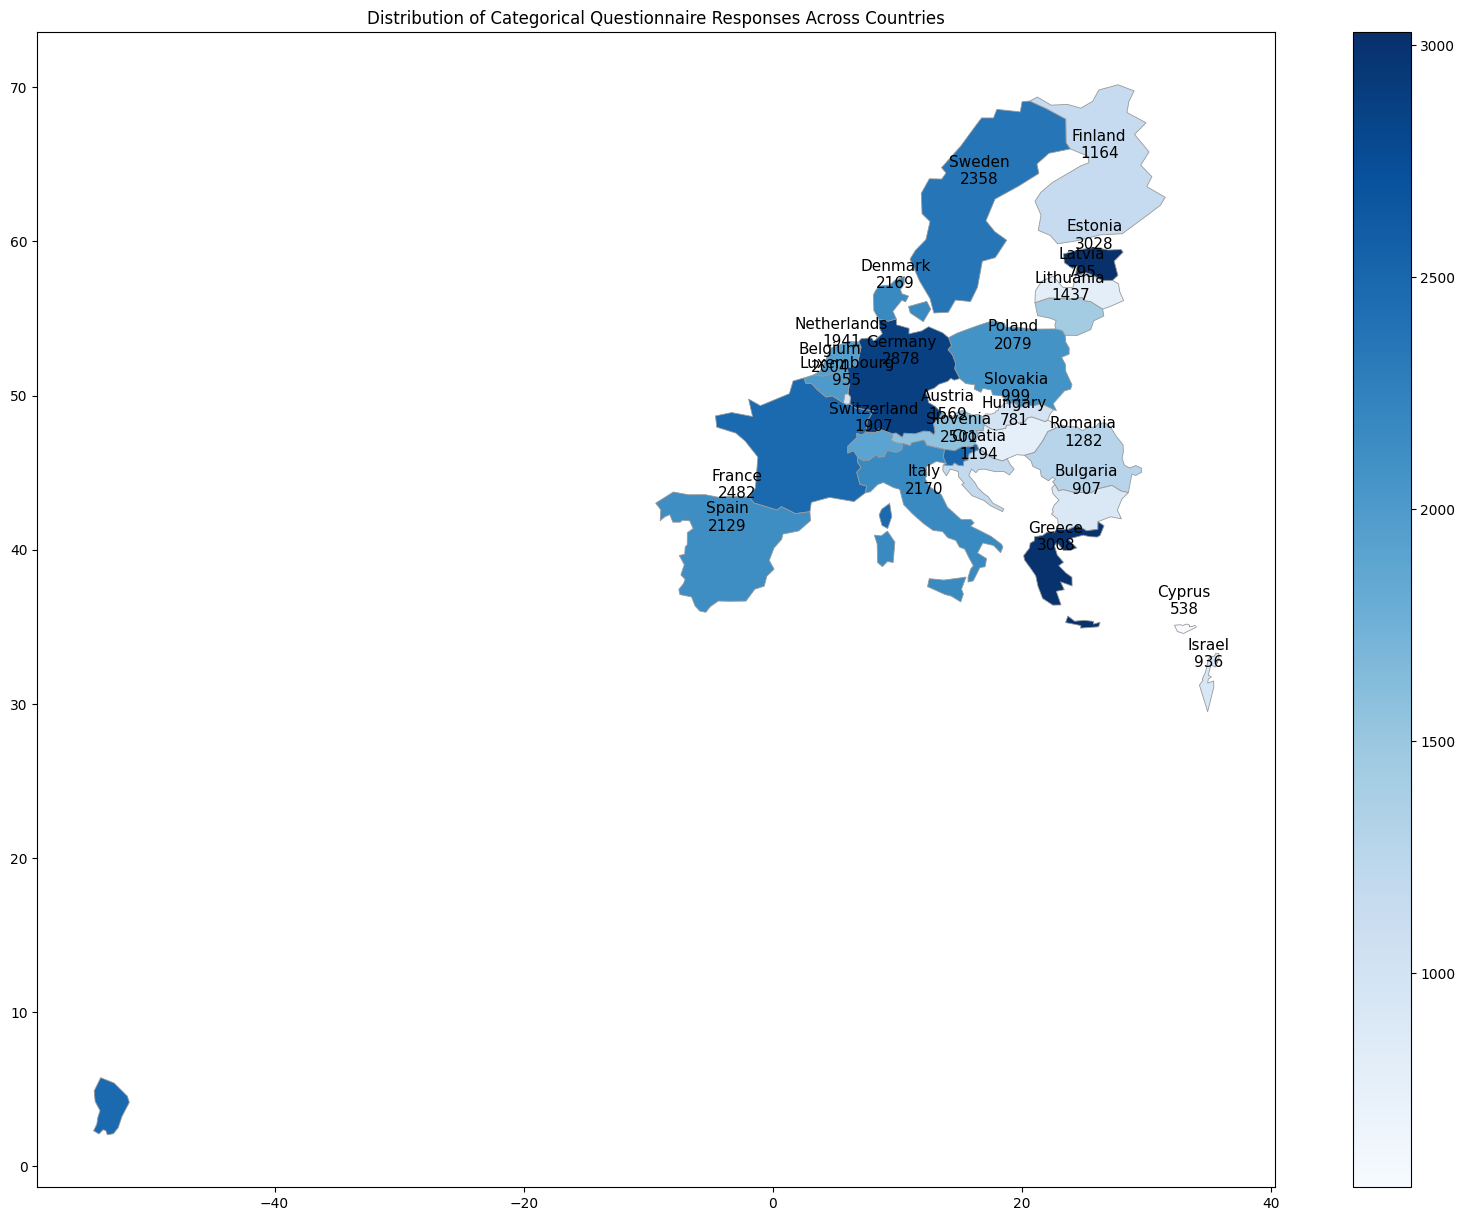

In [13]:
# Count occurrences of each country in the dataset
country_counts = df['country'].value_counts().reset_index()
country_counts.columns = ['name', 'count']

# Download 'naturalearth_lowres' data from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter the world map to include only countries in your dataset
world = world[world['name'].isin(country_counts['name'])]

# Merge the filtered world map with the counts
merged = world.set_index('name').join(country_counts.set_index('name'))

# Plot the map with the counts
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
merged.plot(column='count', cmap='Blues', linewidth=0.6, ax=ax, edgecolor='0.6', legend=True)

# Display country names without overlap
for country, count in zip(country_counts['name'], country_counts['count']):
  if country not in['Czech Republic', 'Malta']:
    x, y = merged.loc[country, 'geometry'].centroid.x, merged.loc[country, 'geometry'].centroid.y
    plt.annotate(f'{country}\n{count}', (x, y), xytext=(0, 10), textcoords="offset points", ha='center', fontsize=11)

plt.title('Distribution of Categorical Questionnaire Responses Across Countries')
plt.show()

<ipython-input-14-c08a10dfc887>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_int'] = pd.to_numeric(data['age_int'], errors='coerce')


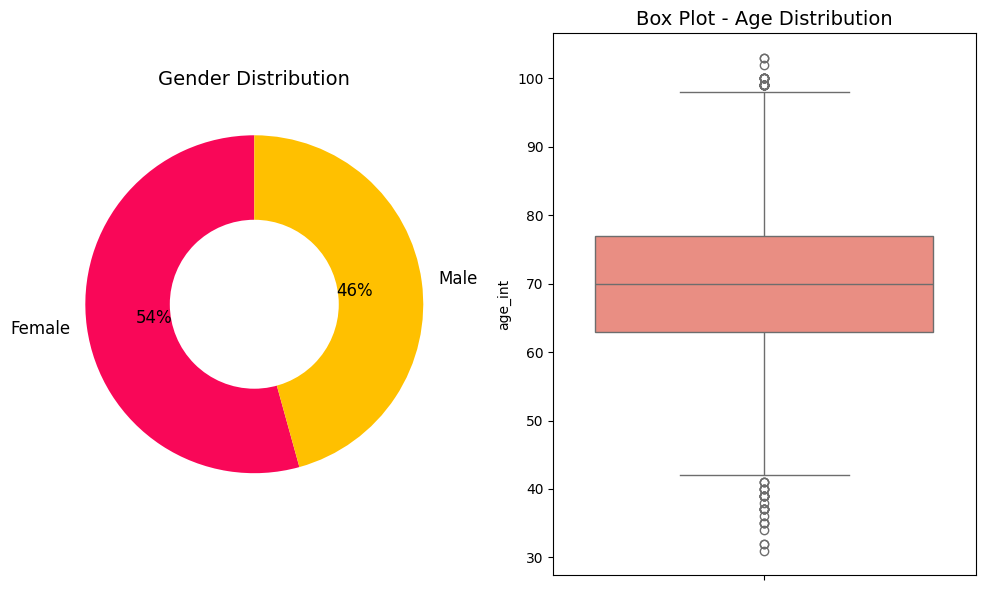

In [14]:
# Convert 'age_int' column to numeric
data['age_int'] = pd.to_numeric(data['age_int'], errors='coerce')
gender_counts = data['gender'].value_counts()

# Drop rows with missing values in 'age_int' column
data = data.dropna(subset=['age_int'])

plt.figure(figsize=(10, 6))

# Pie Chart
plt.subplot(1, 2, 1)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.0f%%', startangle=90, colors=['#F90758','#FFC000'], textprops={'fontsize': 12})

# Draw circle
centre_circle = plt.Circle((0,0),0.50,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Gender Distribution', fontsize=14)

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(y=data['age_int'], color='salmon')
plt.title('Box Plot - Age Distribution', fontsize=14)

plt.tight_layout()
plt.show()

In [15]:
# Calculate the percentage of missing values for each column
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

,Column,Missing Percentage
0,ep130_10,100.00
1,ep133_12,100.00
2,ep130_11,100.00
3,ep130_12,100.00
4,ep130_13,100.00
...,...,...
797,ph005_,0.16
798,gender,0.00
799,deceased_update_ca,0.00
800,deceased,0.00


In [16]:
# Delete the features with missing values percentages exceed the threshold
threshold_percentage = 50

# Identify columns with missing percentages greater than the threshold
columns_to_drop = missing_percentage[missing_percentage > threshold_percentage].index

# Drop columns with high missing percentages
data = data.drop(columns=columns_to_drop)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46733 entries, 0 to 46732
Columns: 228 entries, age_int to cf837_
dtypes: category(227), float64(1)
memory usage: 11.2 MB


In [17]:
data['deceased'].value_counts()

Alive       46733
Deceased        0
Name: deceased, dtype: int64

In [18]:
# Drop duplicate rows and keep the first occurrence
data.drop_duplicates(inplace=True)

# Handle the missing values
# Iterate over each column
for column in data.columns:
    # Check if the column is categorical
    if data[column].dtype == 'category':
        # For categorical columns, fill missing values with the mode of the column
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        # For numerical columns, fill missing values with the mean of the column
        data[column].fillna(data[column].mean(), inplace=True)

# Calculate the new percentage of missing values
missing_percentage = (data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
missing_df = pd.DataFrame({
    'Column': missing_percentage.index,
    'Missing Percentage': missing_percentage.values
})

# Sort the DataFrame by missing percentage in descending order
missing_df = missing_df.sort_values(by='Missing Percentage', ascending=False).reset_index(drop=True)
missing_df

,Column,Missing Percentage
0,age_int,0.0
1,hc841d7,0.0
2,hc841dot,0.0
3,hc843d1,0.0
4,hc843d2,0.0
...,...,...
223,ph049d7,0.0
224,ph049d8,0.0
225,ph049d9,0.0
226,ph049d10,0.0


In [19]:
missing_df

,Column,Missing Percentage
0,age_int,0.0
1,hc841d7,0.0
2,hc841dot,0.0
3,hc843d1,0.0
4,hc843d2,0.0
...,...,...
223,ph049d7,0.0
224,ph049d8,0.0
225,ph049d9,0.0
226,ph049d10,0.0


In [20]:
data['deceased'].value_counts()

Alive       46707
Deceased        0
Name: deceased, dtype: int64

#Feature Engineering

In [21]:
value_mapping = {
'Alive':0,
'Deceased':1,
'Yes': 1,
'No': 0,
'Poor': 1,
'Fair': 2,
'Good': 3,
'Very good': 4,
'Excellent': 5,
'Refusal': 6,
"Don't know": 7,
'Not limited': 0,
'Limited, but not severely': 1,
'Severely limited': 2,
'Selected': 1,
'Not selected': 0,
'Respondent only': 1,
'Proxy only': 2,
'Respondent and proxy': 3,
'Any hopes mentioned': 1,
'No hopes mentioned': 0,
'No such feelings': 0,
'Any mention of suicidal feelings or wish to b...': 1,
'Mentions guilt or self-blame but unclear': 1,
'Obvious excessive guilt or self-blame': 2,
'Trouble with sleep or recent change in pattern': 1,
'No trouble sleeping': 0,
'No mention of loss of interest': 0,
'Less interest than usual mentioned': 1,
'Non-specific or uncodeable response': 2,
'No diminution in desire for food': 0,
'Diminution in desire for food': 1,
'No such difficulty mentioned': 0,
'Difficulty in concentrating': 1,
'Mentions any enjoyment from activity': 1,
'Fails to mention any enjoyable activity': 0,
'Respondent': 1,
'Section not answered (proxy interview)': 0,
'Hardly ever or never': 0,
'Some of the time': 1,
'Often': 2,
'Yes, temporarily': 1,
'Yes, permanently': 2,
'Somewhat satisfied': 3,
'Somewhat dissatisfied': 2,
'Very satisfied': 4,
'Very dissatisfied': 1,
'Sometimes': 2,
'Never': 0,
'Always': 3,
'Rarely': 1,
'Retired': 0,
'Homemaker': 2,
'Other': 9,
'Employed or self-employed (including working ...,': 1,
'Unemployed': 4,
'Permanently sick or disabled': 3,
'Calendar month/4 weeks': 3,
'One week': 1,
'Full year/12 months/52 weeks': 6,
'Three months/13 weeks': 4,
'Six months/26 weeks': 5,
'Two weeks' : 2,
'Given correctly': 1,
"Given incorrectly/doesn't know": 0,
'Same': 2,
'Worse': 1,
'Better': 3,
'Continue': 1,
'Correct': 1,
'Incorrect': 0,
'Wants to start over': 1,
'Correctly described': 1,
'Not correct': 0,
'Fully correct copy': 2,
'Incorrect copy': 0,
'Drawing is impossible due to physical reasons': 0,
'Partially correct copy': 1,
}

In [22]:
# Apply mapping to the entire DataFrame
data
data = data.applymap(lambda x: value_mapping.get(x, x))

# The following features were deleted since it is assumed that they do no contain relevant information
data = data.drop(columns=["ft021_", "ep210_", "ph054_", "hc602_",  "hc876_",  "hc877_",  "ep078e_1",  "ep208_1",  "cf010_",  "cf108_",  "cf109_",  "cf110_",  "cf111_",  "cf112_"], axis=1)
data = data.drop(["cf820_", "cf832_", "cf833_", "cf836_"], axis=1)
# Convert categorical features to numbers so they can be digested by ML models

from sklearn.preprocessing import LabelEncoder

# Creating a instance of label Encoder.
le = LabelEncoder()
data['gender']= le.fit_transform(data['gender'])

data = pd.get_dummies(data, columns=data.select_dtypes(include=['object']).columns)

data.head(3)

,age_int,gender,mh002_,mh003_,mh005_,mh007_,mh008_,mh010_,mh011_,mh013_,...,mh004__7,mh004__Any mention of suicidal feelings or wish to be dead,ep005__0,ep005__2,ep005__3,ep005__4,ep005__6,ep005__7,ep005__9,ep005__Employed or self-employed (including working for family business)
0,80.0,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,68.0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,68.0,1,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [23]:
data["cf018_"] = data["cf018d1"].apply(lambda x: 0 if x == 0 else 1)
data = data.drop(["cf018d1","cf018d2","cf018d3","cf018d4"], axis=1)

#Correlation Analysis

In [24]:
# First the description of each feature is uploaded to facilitate the reading of the association output
feature_description_df = pd.read_excel('/content/drive/MyDrive/Share_dataset/labels (1).xlsx')

# Create a dictionary mapping feature names to descriptions
feature_description_mapping = dict(zip(feature_description_df['Variable Name'], feature_description_df['Variable Label']))

Feature pairs with correlation > 0.7:
Features: Date: day of month (cf003_) and Date: month (cf004_), Correlation Measure: 0.87
Features: Date: day of month (cf003_) and Date: year (cf005_), Correlation Measure: 0.87
Features: Date: day of month (cf003_) and Date: day of the week (cf006_), Correlation Measure: 0.86
Features: Date: day of month (cf003_) and Describe object: scissors (cf827_), Correlation Measure: 0.70
Features: Date: day of month (cf003_) and Describe object: pharmacy (cf829_), Correlation Measure: 0.71
Features: Date: month (cf004_) and Date: year (cf005_), Correlation Measure: 0.95
Features: Date: month (cf004_) and Date: day of the week (cf006_), Correlation Measure: 0.95
Features: Date: month (cf004_) and Contextual factors during the cognitive function test (cf017_), Correlation Measure: 0.71
Features: Date: month (cf004_) and Counting backwards: intro 1 (cf821_), Correlation Measure: 0.72
Features: Date: month (cf004_) and Counting backwards: trail 1 end (cf822_),

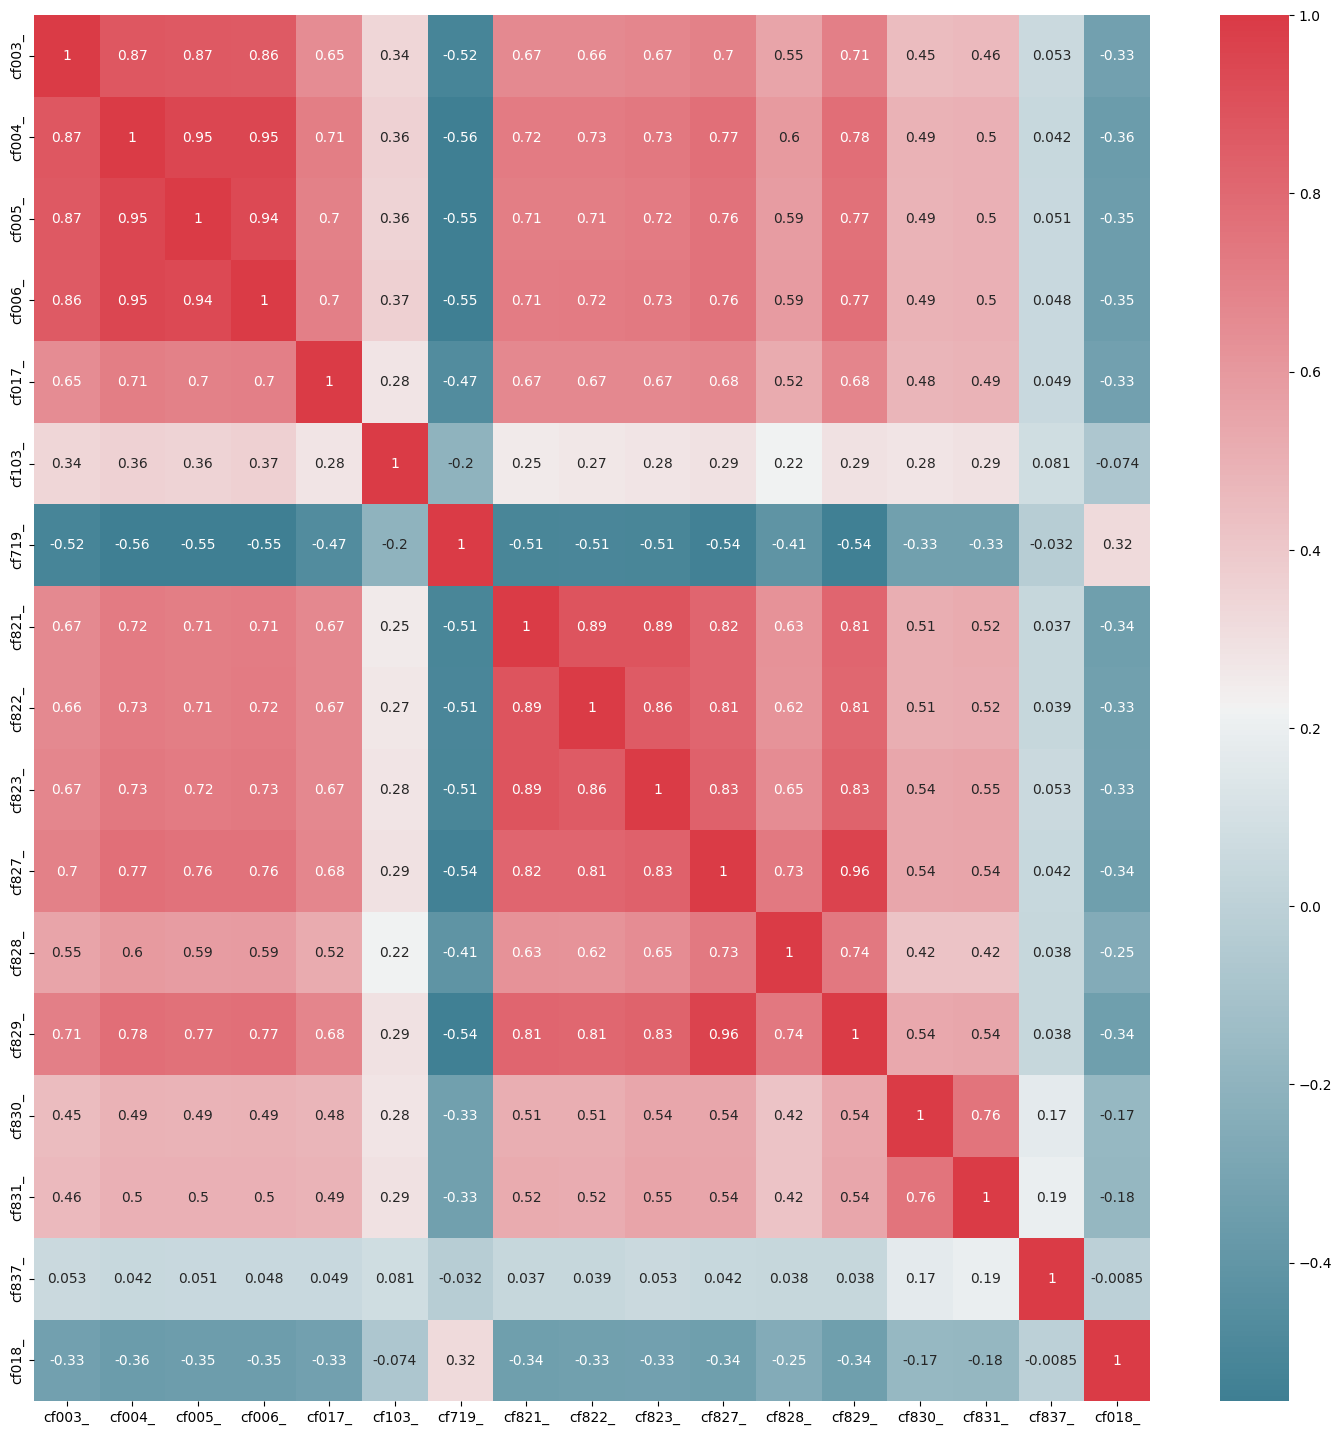

In [25]:
# Visualize the correlation between cognitive features
# Get all columns that start with prefixes "cf"
selected_columns = data.filter(regex='^cf', axis=1)

# Combine selected columns with their names
cognitive_data = data[selected_columns.columns.tolist()]

correlation_matrix = cognitive_data.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(feature_pair)

# Display features with correlation exceeding the threshold
print("Feature pairs with correlation > 0.7:")
for feature_pair in high_corr_pairs:
    description_i = feature_description_mapping.get(feature_pair[0], feature_pair[0])
    description_j = feature_description_mapping.get(feature_pair[1], feature_pair[1])
    print(f"Features: {description_i} ({feature_pair[0]}) and {description_j} ({feature_pair[1]}), Correlation Measure: {correlation_matrix.loc[feature_pair[0], feature_pair[1]]:.2f}")

The heatmap illustrates the correlation coefficients between different cognitive features, each denoted by a prefix "cf" and a number. These coefficients range from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and values close to 0 indicate no correlation.

Analyzing the output:

High Correlation (> 0.7): A large number of features show a high positive correlation with each other, particularly between different date-related features (cf003_ to cf006_). This is expected as date components (day, month, year) are intrinsically related.
Cognitive Tests Correlation: There are strong correlations between different cognitive tests, like counting backwards (cf821_, cf822_, cf823_) and describing objects (cf827_, cf829_), which suggests that these tests may be measuring similar cognitive abilities or have some overlap in what they assess.
Redundancy: The strong correlations suggest redundancy; for example, cf821_ (Counting backwards: intro 1) and cf822_ (Counting backwards: trail 1 end) have a correlation measure of 0.89, indicating that these features may be conveying similar information.

In [26]:
# Delete the features with strong assosciation
data = data.drop(["cf004_", "cf005_", "cf006_", "cf821_", "cf822_", "cf823_", "cf827_", "cf828_", "cf829_", "cf830_"], axis=1)

Feature pairs with correlation > 0.7:
Features: Sad or depressed last month (mh002_) and Hopes for the future (mh003_), Correlation Measure: 0.71
Features: Sad or depressed last month (mh002_) and Feels guilty (mh005_), Correlation Measure: 0.76
Features: Sad or depressed last month (mh002_) and Trouble sleeping (mh007_), Correlation Measure: 0.78
Features: Sad or depressed last month (mh002_) and Less or same interest in things (mh008_), Correlation Measure: 0.77
Features: Sad or depressed last month (mh002_) and Irritability (mh010_), Correlation Measure: 0.78
Features: Sad or depressed last month (mh002_) and Appetite (mh011_), Correlation Measure: 0.77
Features: Sad or depressed last month (mh002_) and Fatigue (mh013_), Correlation Measure: 0.77
Features: Sad or depressed last month (mh002_) and Concentration on entertainment (mh014_), Correlation Measure: 0.78
Features: Sad or depressed last month (mh002_) and Concentration on reading (mh015_), Correlation Measure: 0.72
Features: 

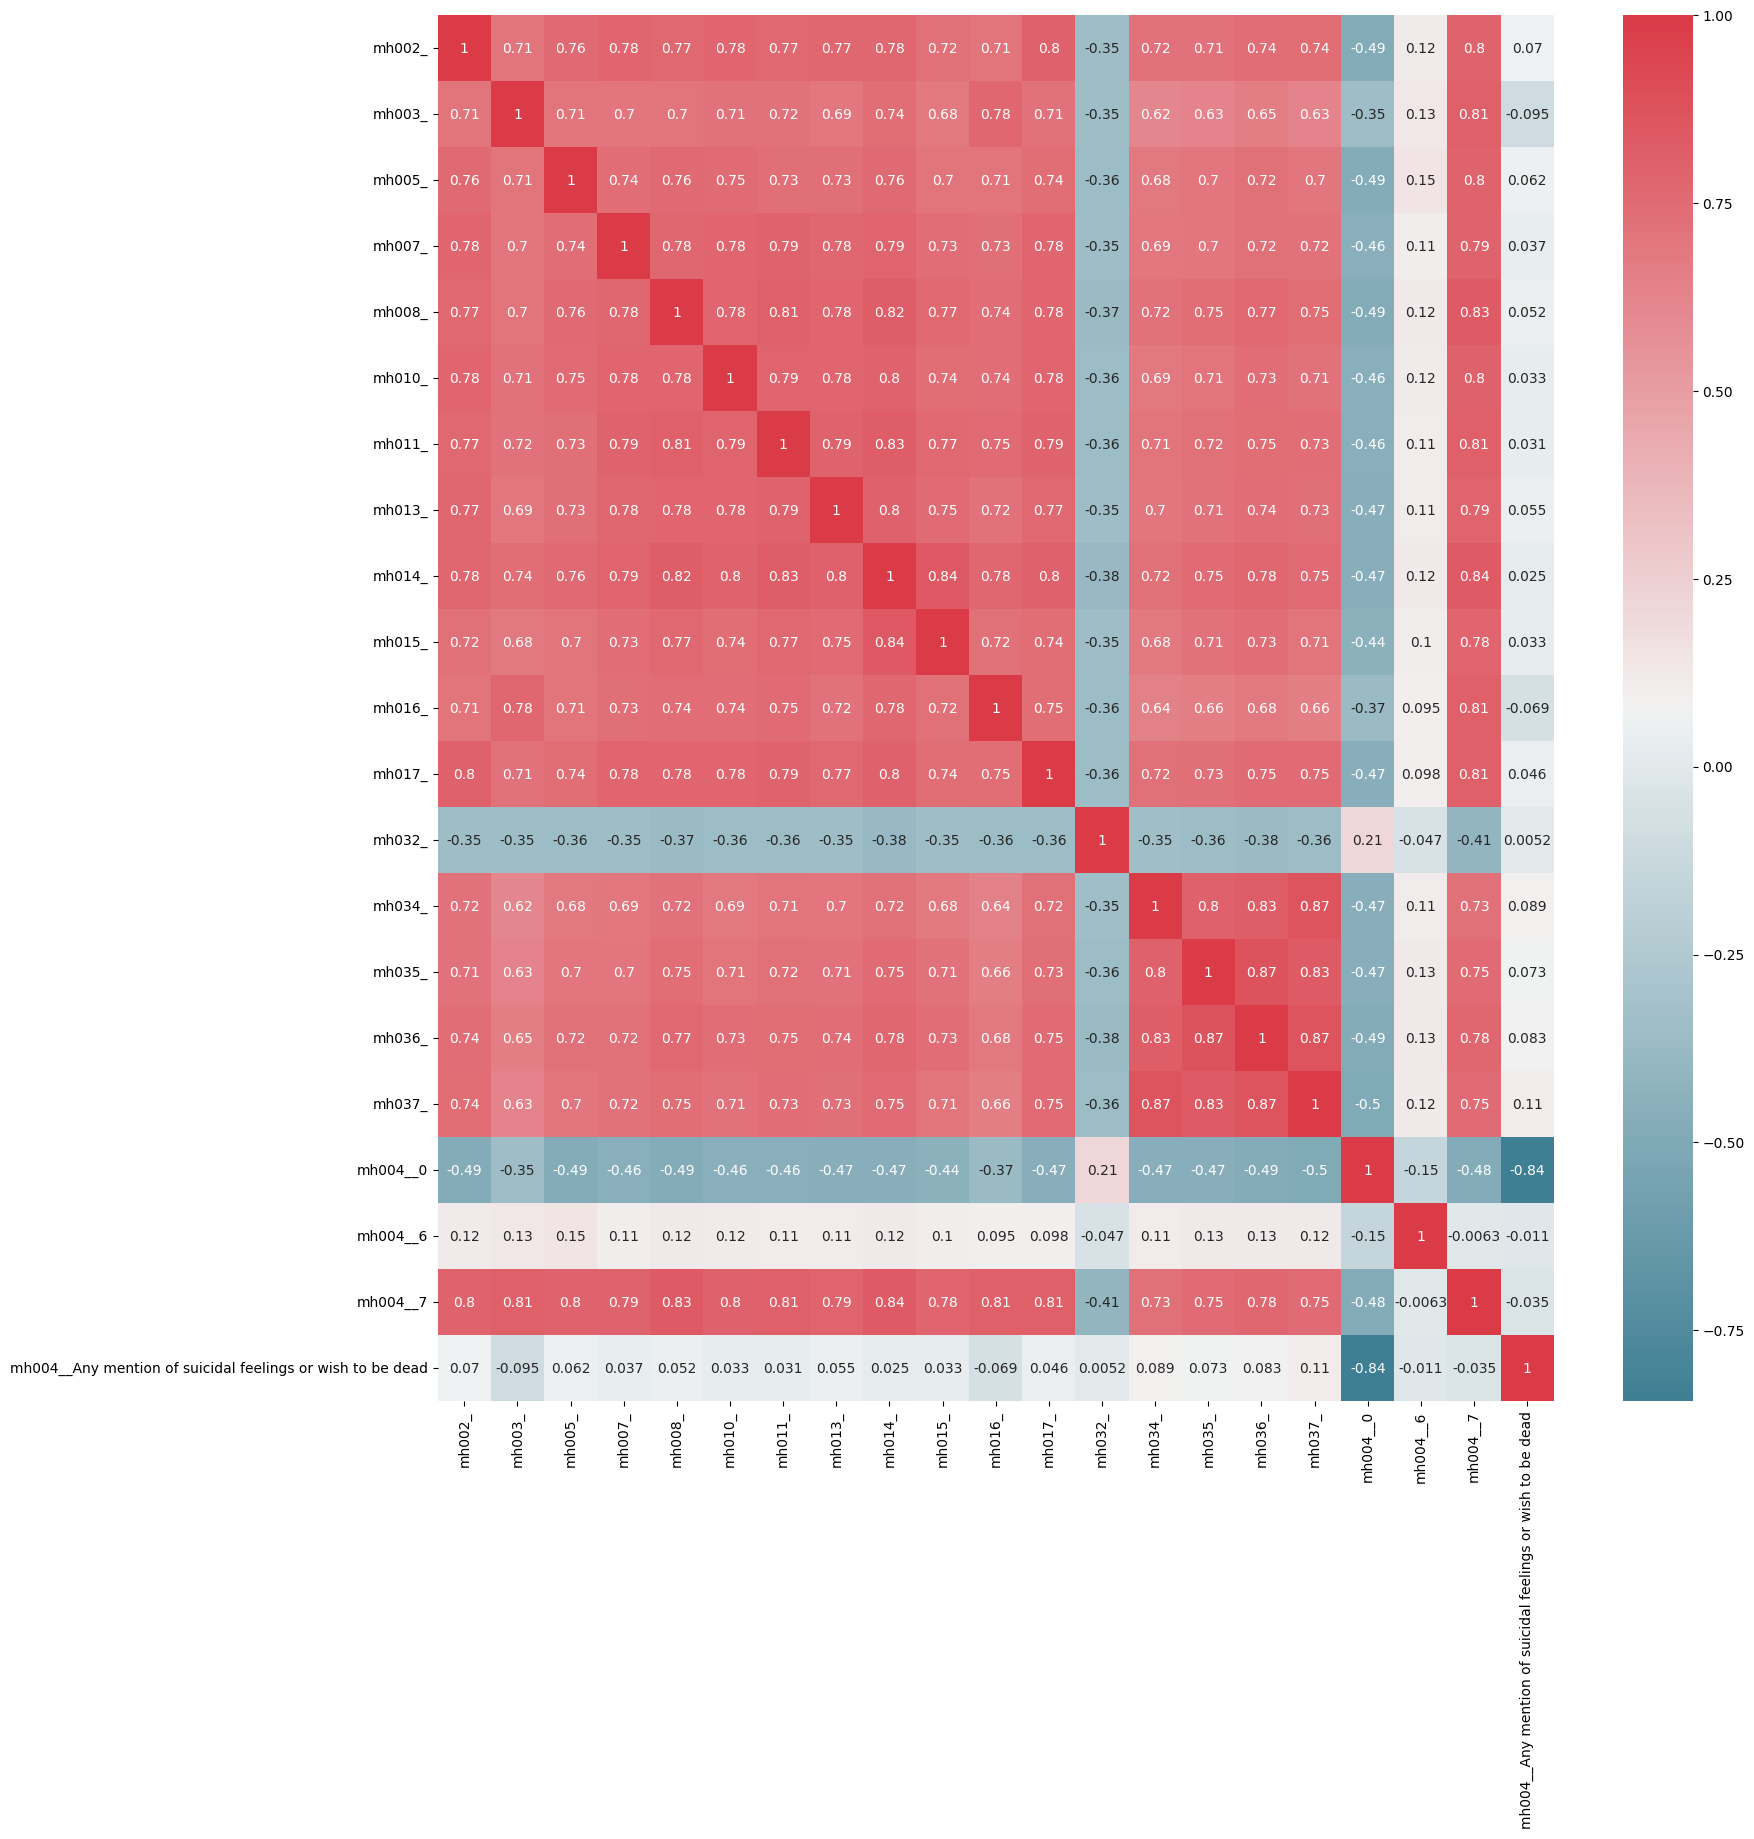

In [27]:
# Visualize the correlation between mental health features
# Get all columns that start with prefixes "mh"
selected_columns = data.filter(regex='^mh', axis=1)

# Combine selected columns with their names
mental_data = data[selected_columns.columns.tolist()]

correlation_matrix = mental_data.corr()

_,ax=plt.subplots(figsize=(18,18))
colormap=sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(correlation_matrix,annot=True,cmap=colormap)

# Set the correlation threshold
threshold = 0.7

# Find features with correlation above the threshold
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            high_corr_pairs.append(feature_pair)

# Display features with correlation exceeding the threshold
print("Feature pairs with correlation > 0.7:")
for feature_pair in high_corr_pairs:
    description_i = feature_description_mapping.get(feature_pair[0], feature_pair[0])
    description_j = feature_description_mapping.get(feature_pair[1], feature_pair[1])
    print(f"Features: {description_i} ({feature_pair[0]}) and {description_j} ({feature_pair[1]}), Correlation Measure: {correlation_matrix.loc[feature_pair[0], feature_pair[1]]:.2f}")

The heatmap of the mental health features (denoted with "mh") demonstrates the relationships between different aspects of mental health, measured by a range of indicators. High correlation scores (above 0.7) suggest that certain feelings, behaviors, or symptoms often occur together or are perceived similarly by individuals.

From the output , here are some insights:

Strong Associations: There are strong positive correlations among various mental health features. For instance, feeling sad or depressed (mh002_) is highly correlated with trouble sleeping (mh007_), irritability (mh010_), fatigue (mh013_), and tearfulness (mh017_). This pattern suggests that these symptoms often manifest together, which is consistent with common understandings of depressive symptoms.

Overlap in Measurement: The high correlations might indicate an overlap in what these features measure, which could be due to the multifaceted nature of mental health where certain symptoms are connected.

Negative Correlation: There is a notable negative correlation between mh004__0 and mh004__Any mention of suicidal feelings or wish to be dead. This suggests that when the mention of suicidal feelings is present, it is likely to be associated with a specific response in mh004__0, which could be a lack of such feelings or thoughts.

In [28]:
# Delete the features with strong assosciation


data = data.drop(["mh002_", "mh003_", "mh005_", "mh007_", "mh008_", "mh010_", "mh011_", "mh013_", "mh014_", "mh015_", "mh016_", "mh017_", "mh034_", "mh035_", "mh036_", "mh037_"], axis=1)
data = data.drop(["mh032_", "mh004__6", "cf719_"], axis=1)
data=data[(data['ph006d16']==1) | (data['ph006d16']==0)]


In [29]:
# Extract the output features
selected_columns = data.filter(regex='^(mh|cf)', axis=1).columns
X = data.drop(selected_columns, axis=1)
y = data['ph006d16']

X =X.drop(['ph006d16','deceased'], axis=1)
# The features with type float64 were converted to integers since their values are assumed to be integers
#float_columns = y.select_dtypes(include=['float64']).columns.tolist()
#y = y.astype({col: 'int' for col in float_columns})



In [30]:
X['ph011d10']  ## anxiety or depression

0        0
1        0
2        0
3        1
4        0
        ..
46728    0
46729    1
46730    0
46731    0
46732    0
Name: ph011d10, Length: 46645, dtype: int64

Late-life depression and the risk of dementia analysis with Cox Model implementation

In [31]:
pip install lifelines==0.26.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 6.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b111103a45da2f324f7cd695c22ff14599ad85541b5eb5077d5007534d4c0f8e
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


<Axes: xlabel='timeline'>

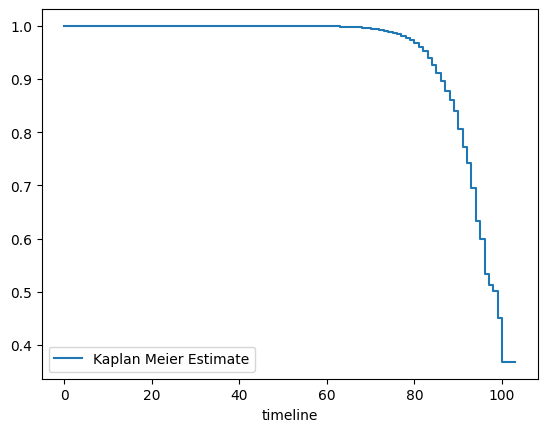

In [32]:
from lifelines import KaplanMeierFitter

T = data.age_int
E = data.ph006d16

## create a kmf object
km = KaplanMeierFitter()

## Fit the data into the model
km.fit(T, E,label='Kaplan Meier Estimate')

## Create an estimate
km.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, not showing it.

<Axes: xlabel='timeline'>

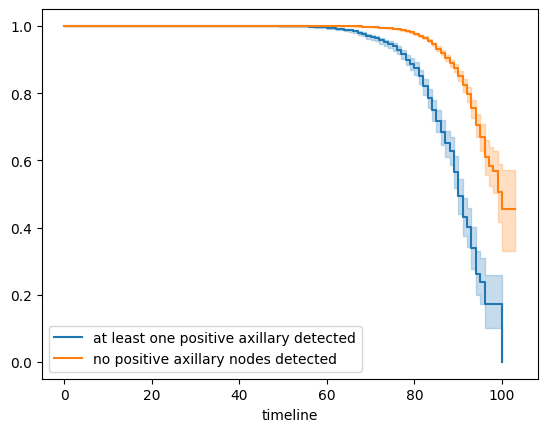

In [33]:
km_2 = KaplanMeierFitter()

## creating 2 cohorts : with at least one positive axillary detected, and one with no one detected
groups = data['ph011d10']
i1 = (groups >= 1)
i2 = (groups < 1)


## fit the model for 1st cohort
km_2.fit(T[i1], E[i1], label='at least one positive axillary detected')
a1 = km_2.plot()

## fit the model for 2nd cohort
km_2.fit(T[i2], E[i2], label='no positive axillary nodes detected')
km_2.plot(ax=a1)

In [34]:
data.columns

Index(['age_int', 'gender', 'ph003_', 'ph004_', 'ph005_', 'ph006d1', 'ph006d2',
       'ph006d3', 'ph006d4', 'ph006d5',
       ...
       'mh004__Any mention of suicidal feelings or wish to be dead',
       'ep005__0', 'ep005__2', 'ep005__3', 'ep005__4', 'ep005__6', 'ep005__7',
       'ep005__9',
       'ep005__Employed or self-employed (including working for family business)',
       'cf018_'],
      dtype='object', length=188)

In [35]:
from lifelines import CoxPHFitter
# Create Model
cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1, l1_ratio=1.0) # sparse solutions,
sample=data.drop(columns=['hc116d1', 'hc116d2', 'ep005__6', 'ep005__7','ep005__3','ph006dno','deceased','deceased_update_ca'] )
sample.dropna(inplace=True)

In [36]:
sample.columns

Index(['age_int', 'gender', 'ph003_', 'ph004_', 'ph005_', 'ph006d1', 'ph006d2',
       'ph006d3', 'ph006d4', 'ph006d5',
       ...
       'cf837_', 'mh004__0', 'mh004__7',
       'mh004__Any mention of suicidal feelings or wish to be dead',
       'ep005__0', 'ep005__2', 'ep005__4', 'ep005__9',
       'ep005__Employed or self-employed (including working for family business)',
       'cf018_'],
      dtype='object', length=180)

In [37]:

# Fit the data to train the model
cph.fit(sample, 'age_int', event_col='ph006d16', show_progress=True)


# Have a look at the significance of the features
#cph.print_summary()

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Iteration 1: norm_delta = 0.40367, step_size = 0.9000, log_lik = -895357.14274, newton_decrement = 907.37306, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.23991, step_size = 0.9000, log_lik = -692200.36343, newton_decrement = 2937.71280, seconds_since_start = 0.9
Iteration 3: norm_delta = 0.19969, step_size = 0.9000, log_lik = -533570.94946, newton_decrement = 352.11845, seconds_since_start = 1.4
Iteration 4: norm_delta = 0.05912, step_size = 1.0000, log_lik = -412491.75012, newton_decrement = 64.93966, seconds_since_start = 1.8
Iteration 5: norm_delta = 0.03515, step_size = 1.0000, log_lik = -319473.75353, newton_decrement = 8.57644, seconds_since_start = 2.1
Iteration 6: norm_delta = 0.03023, step_size = 1.0000, log_lik = -247975.39363, newton_decrement = 6.91296, seconds_since_start = 2.5
Iteration 7: norm_delta = 0.02607, step_size = 1.0000, log_lik = -192986.01596, newton_decrement = 6.65725, seconds_since_start = 2.9
Iteration 8: norm_delta = 0.02244, step_size = 1.0000,

<lifelines.CoxPHFitter: fitted with 46645 total observations, 45481 right-censored observations>

In [38]:
cph.print_summary()

/usr/local/lib/python3.10/dist-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 46645 total observations, 45481 right-censored observations>
             duration col = 'age_int'
                event col = 'ph006d16'
                penalizer = 0.1
                 l1 ratio = 1.0
      baseline estimation = breslow
   number of observations = 46645
number of events observed = 1164
   partial log-likelihood = -9961.96
         time fit was run = 2024-02-17 13:07:23 UTC

---
                                                                           coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                        
gender                                                                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph003_                                                                    -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph004_                                                                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph005_                                                                     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d1                                                                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d2                                                                   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d3                                                                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d4                                                                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d5                                                                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d6                                                                    0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d10                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d11                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d12                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d13                                                                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d14                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d15                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d18                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006d19                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
ph006

<Axes: xlabel='log(HR) (95% CI)'>

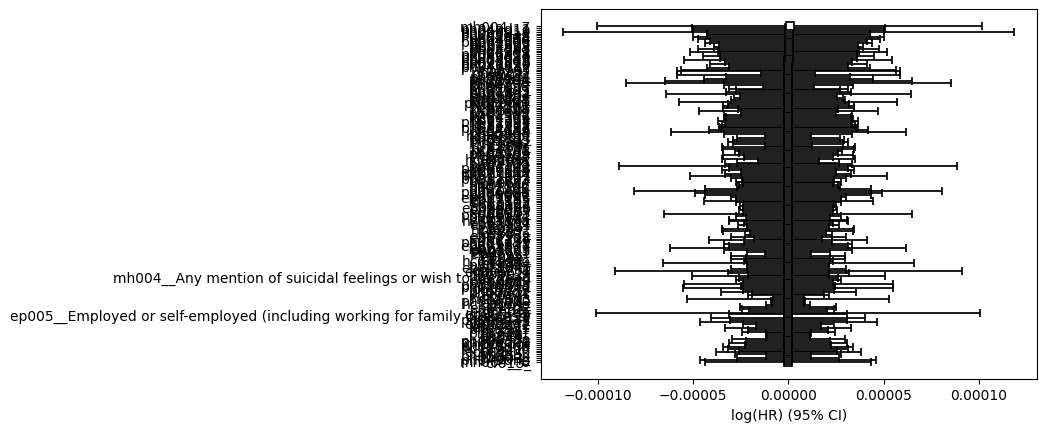

In [39]:
cph.plot()

In [40]:
## I want to see the Survival curve at the patient level.
## Random patients
#patients = [4:211]

rows_selected = data.iloc[1:200, :]
rows_selected

,age_int,gender,ph003_,ph004_,ph005_,ph006d1,ph006d2,ph006d3,ph006d4,ph006d5,...,mh004__Any mention of suicidal feelings or wish to be dead,ep005__0,ep005__2,ep005__3,ep005__4,ep005__6,ep005__7,ep005__9,ep005__Employed or self-employed (including working for family business),cf018_
1,68.0,0,3,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,68.0,1,4,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,89.0,0,1,1,2,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,95.0,1,3,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
5,68.0,1,1,1,2,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,72.0,0,3,1,1,0,1,1,0,1,...,0,1,0,0,0,0,0,0,0,1
196,72.0,1,3,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
197,61.0,1,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
198,55.0,0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


<Axes: >

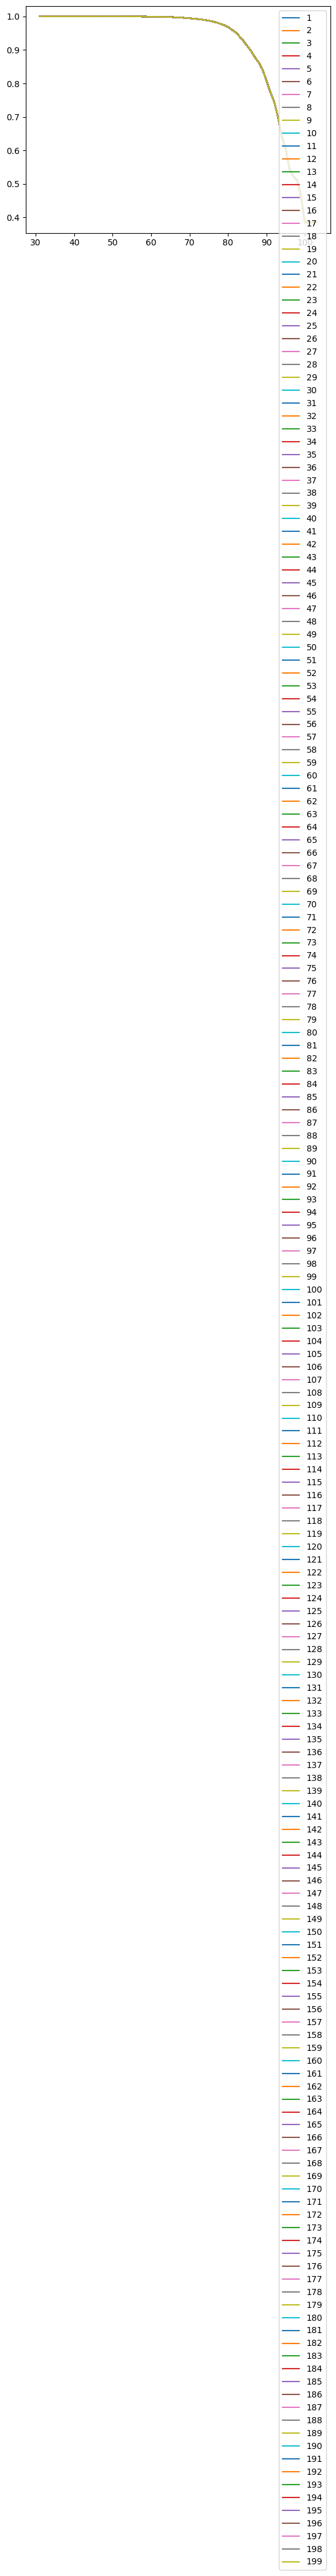

In [41]:
cph.predict_survival_function(rows_selected).plot()

#ML
###XGBoost_SCENARIO 1

In [42]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Split the dataset into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define hyperparameter grid for grid search
param_grid = [{
    'max_depth': [3, 5, 7, 10, 15, 17],
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.9, 1]
}]

print("The model for {} is Training ......")
# Create a base XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_xgb_classifier = xgb.XGBClassifier(**best_params)
final_xgb_classifier.fit(X_train, y_train)



print(f"Best Hyperparameters: {grid_search.best_params_}")
import os
import joblib

# Define the directory where you want to save your models
model_directory = '/content/drive/MyDrive/Share_dataset/model_storage'

# Check if the directory exists, and if not, create it
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

# Specify the path to save the best model and best parameters
model_path = os.path.join(model_directory, 'best_xgb_model1.joblib')
parameters_path = os.path.join(model_directory, 'best_parameters1.joblib')

# Save the best model and best parameters to the specified path
joblib.dump(final_xgb_classifier, model_path)
joblib.dump(grid_search.best_params_, parameters_path)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Model saved to {model_path}")
print(f"Best parameters saved to {parameters_path}")

The model for {} is Training ......
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Model saved to /content/drive/MyDrive/Share_dataset/model_storage/best_xgb_model1.joblib
Best parameters saved to /content/drive/MyDrive/Share_dataset/model_storage/best_parameters1.joblib


In [43]:
np. unique(y_train, return_counts=True)

(array([0, 1]), array([36385,   931]))

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred = final_xgb_classifier.predict(X_test)
#y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores = final_xgb_classifier.predict_proba(X_test)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep)


Overall Results:
Accuracy: 97.94 %
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      9096
           1       0.71      0.30      0.42       233

    accuracy                           0.98      9329
   macro avg       0.84      0.65      0.71      9329
weighted avg       0.98      0.98      0.98      9329



<Figure size 1000x800 with 0 Axes>

In [45]:
y_scores

array([[9.9995160e-01, 4.8425838e-05],
       [9.9997067e-01, 2.9337238e-05],
       [9.9810398e-01, 1.8960409e-03],
       ...,
       [6.5136993e-01, 3.4863004e-01],
       [9.9813294e-01, 1.8670755e-03],
       [9.8793554e-01, 1.2064466e-02]], dtype=float32)

In [46]:
from sklearn.preprocessing import OneHotEncoder
# Create an instance of One-hot-encoder
enc = OneHotEncoder()
y_test_encoded=enc.fit_transform( pd.DataFrame(y_test)).toarray()
#    data[['Gen_new', 'Rem_new']]).toarray())

In [47]:
auc = np.round(roc_auc_score(y_test, y_pred), 3)
print("Auc for our sample data is {}".format(auc))


Auc for our sample data is 0.649


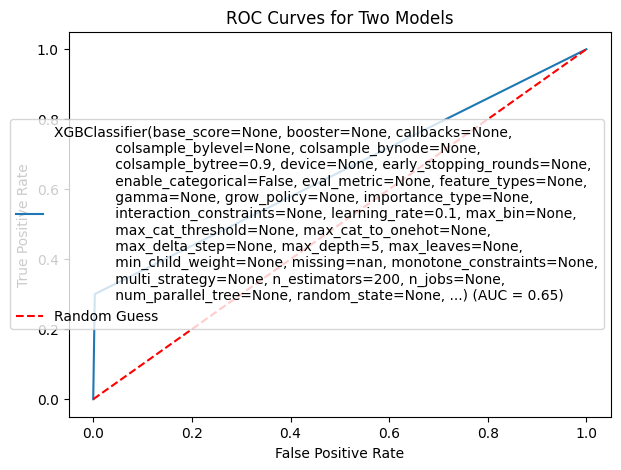

In [48]:
# Plot ROC curve for each model
auc = np.round(roc_auc_score(y_test, y_pred), 3)

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_test, y_pred)
#roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{final_xgb_classifier} (AUC = {auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

### brier_score_loss

In [49]:
from sklearn.metrics import brier_score_loss
probs = y_scores  [:, 1]
brier_score_loss(y_test, probs)

0.017331801771192992

In [50]:
y_scores= final_xgb_classifier.predict_proba(X_test)
y_scores

array([[9.9995160e-01, 4.8425838e-05],
       [9.9997067e-01, 2.9337238e-05],
       [9.9810398e-01, 1.8960409e-03],
       ...,
       [6.5136993e-01, 3.4863004e-01],
       [9.9813294e-01, 1.8670755e-03],
       [9.8793554e-01, 1.2064466e-02]], dtype=float32)

In [51]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

cal_clf = CalibratedClassifierCV(final_xgb_classifier, method="sigmoid", cv="prefit")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=0.9,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.1, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=5,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=200, n_jobs=None,
                                               num_parallel_tree=None,
                                               random_state=None, ...))

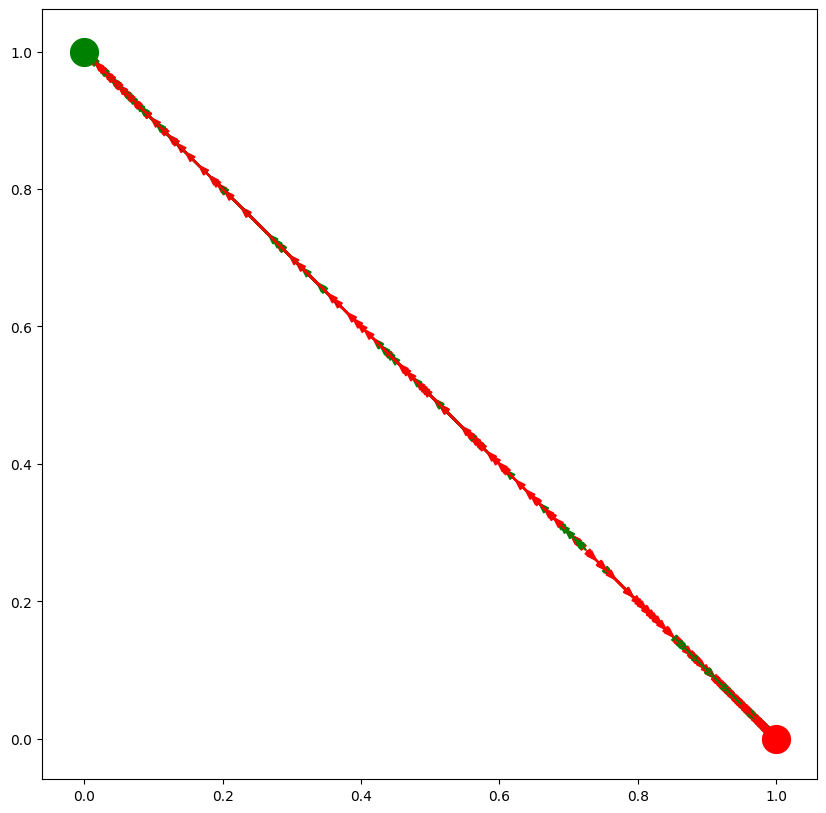

In [52]:
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
colors = ["r", "g", "b"]

clf_probs=y_scores
#clf_probs = clf.predict_proba(X_test)

cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test.iloc[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")


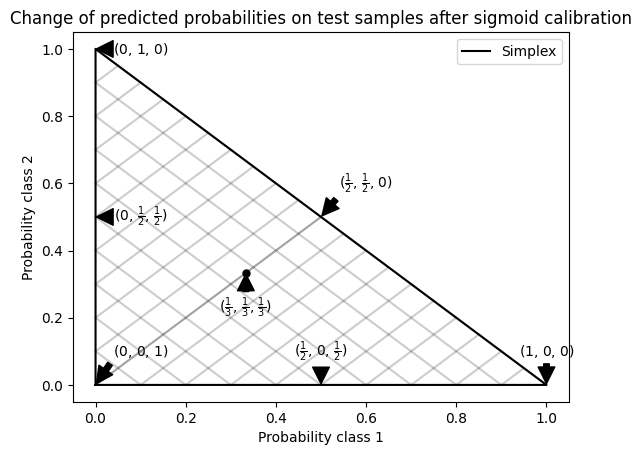

In [53]:

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

**Model Training and Performance:**

The XGBoost model was trained using a grid search to optimize hyperparameters over a predefined range. The best hyperparameters were determined based on the accuracy score during cross-validation.

The final model achieved a very high accuracy of 97.94% on the test set, which is indicative of excellent predictive performance.

**Model Evaluation:**

The classification report shows very high precision and recall for class 0, which suggests that the model performs extremely well for this class. However, for class 1, precision is moderate, and recall is quite low, indicating that the model struggles with correctly identifying this class.

The overall weighted average metrics are still very high due to the class imbalance (class 0 being the majority class).

**Brier Score:**

The Brier score for the positive class (class 1) is 0.0173, which is quite low and indicates good performance in terms of the reliability of the probability estimates.

**ROC Curve:**

The ROC curve plot indicates an AUC (Area Under the Curve) of 0.65, which is relatively low compared to the high accuracy of the model. This might suggest that the model's performance varies greatly between classes, or there might be an imbalance in class distribution.

**Calibration Plots:**

The provided simplex plot is a reference plot showing ideal locations for predicted probabilities but does not contain any data points or arrows indicating the actual calibration changes.

The second plot with arrows is not provided for this model, so calibration changes cannot be assessed visually.
The ROC curve plot does not show the effect of calibration; instead, it provides a comparison of the model's discriminatory capability with the random guess line.

**Key Observations and Recommendations:**

The high accuracy but moderate AUC suggests that while the model is highly accurate overall, its ability to discriminate between classes (especially the minority class) is not as strong. This is corroborated by the classification report which shows a substantial difference in recall between classes.

The low Brier score is encouraging as it suggests that the probability estimates for class 1 are reliable.
It may be beneficial to address the class imbalance, possibly by gathering more data for class 1, using techniques like SMOTE, or adjusting class weights in the XGBoost algorithm.

To further assess the calibration of the model, a calibration curve or reliability plot should be examined, and a pre- and post-calibration comparison should be made.

The effectiveness of the calibration can also be quantified by comparing Brier scores or log loss before and after calibration.

In conclusion, the XGBoost model is performing well, particularly for the majority class.

### Handle Imabalance data

Class=0, n=45481 (97.505%)
Class=1, n=45481 (97.505%)


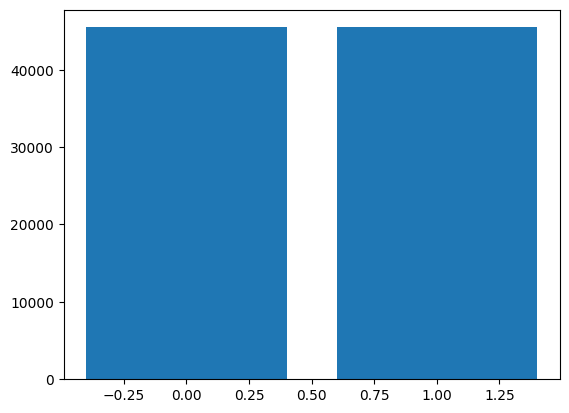

In [54]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

# transform the dataset
oversample = SMOTE()
X_New, y_New = oversample.fit_resample(X, y)
counter = Counter(y_New)
for k,v in counter.items():
 per = v / len(y) * 100
 print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()



<Axes: xlabel='timeline'>

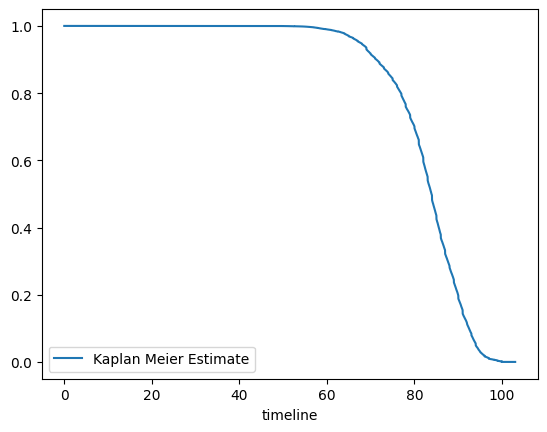

In [55]:
from lifelines import KaplanMeierFitter

T = X_New.age_int
E = y_New

## create a kmf object
km = KaplanMeierFitter()

## Fit the data into the model
km.fit(T, E,label='Kaplan Meier Estimate')

## Create an estimate
km.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, not showing it.

In [56]:
from lifelines import CoxPHFitter
# Create Model
cph = CoxPHFitter()

# Fit the data to train the model
cph.fit(X_New, 'age_int')

# Have a look at the significance of the features
#cph.print_summary()

<lifelines.CoxPHFitter: fitted with 90962 total observations, 0 right-censored observations>

**Kaplan-Meier Fitter:**

The Kaplan-Meier estimator is a non-parametric statistic used to estimate the survival function from lifetime data.
In your code, the KaplanMeierFitter object is being used to fit the data based on age_int and E (which likely represents event occurrence such as death, failure, etc.).

The .plot(ci_show=False) suggests that you've plotted the survival function without the confidence interval, which is appropriate if the dataset is too small since confidence intervals might be too wide to be informative.

**Cox Proportional Hazards Model:**

The Cox Proportional Hazards model (CoxPHFitter) is a semi-parametric model used for survival analysis. It allows you to analyze the effect of several variables at once and determine how they influence the time until a specified event occurs.

You've fitted this model to X_New with age_int as the time duration. However, the event column isn't specified, which might be a mistake because the Cox model requires both the duration and the event indicator.

The comment #cph.print_summary() suggests you have the capability to print a summary of the model fit, which would include the regression coefficients, their significance, and other diagnostic metrics like the concordance index.

**Observations:**

The CoxPHFitter output shows that it was fitted with 90,962 observations, with no right-censored observations. This could indicate that all individuals in the dataset experienced the event (assuming E is binary with 0 for censored and 1 for event).

The absence of right-censored data might simplify the analysis but could also limit the generalizability of the model to broader populations where censored observations are common.

**Considerations for Analysis:**

A Kaplan-Meier plot would typically show the proportion of subjects living for a certain amount of time after treatment. It can be used to visualize the survival distribution of life-times.

The Cox model can be used to understand the impact of various covariates on survival.

It is important to check the proportional hazards assumption in the Cox model to ensure the model is valid over time.
To compare the Cox model's performance or fit, one could look at the concordance index (which is similar to the AUC for ROC curves), likelihood ratio tests, Wald tests, or the score (log-rank) tests from the summary.

**Conclusion:**


The Kaplan-Meier estimator and the Cox model are tools for different purposes compared to predictive models like XGBoost or Logistic Regression. While the latter are used for prediction based on patterns in data, survival analysis is specifically used for analyzing and predicting the time until an event of interest.

In [57]:
# Assuming X and y are your features and target variable
X_train_New, X_test_New, y_train_New, y_test_New = train_test_split(X_New, y_New, test_size=0.2, random_state=2)

label_encoder = LabelEncoder()
y_train_New_encoded = label_encoder.fit_transform(y_train_New)
y_test_New_encoded = label_encoder.transform(y_test_New)

# Define hyperparameter grid for grid search
param_grid = [{
    'max_depth': [3, 5, 7, 10, 15, 17],
    'learning_rate': [0.1],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.9, 1]
}]

print("The model for {} is Training ......")
# Create a base XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_New, y_train_New_encoded)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the final model with the best hyperparameters
final_xgb_classifier = xgb.XGBClassifier(**best_params)
final_xgb_classifier.fit(X_train_New, y_train_New_encoded)

# Save the best model
joblib.dump(final_xgb_classifier, 'best_xgb_model_ADNI1_New.joblib')

# Save the best_params
joblib.dump(best_params, 'best_parameters_ADNI1_New.joblib')

The model for {} is Training ......
Best Hyperparameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 200, 'subsample': 0.9}


['best_parameters_ADNI1_New.joblib']

In [58]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_pred_New_encoded = final_xgb_classifier.predict(X_test_New)
y_pred_New = label_encoder.inverse_transform(y_pred_New_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test_New, y_pred_New)
classification_rep_New = classification_report(y_test_New, y_pred_New)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores_New = final_xgb_classifier.predict_proba(X_test_New)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep_New)


Overall Results:
Accuracy: 99.02 %
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      9287
           1       0.99      0.99      0.99      8906

    accuracy                           0.99     18193
   macro avg       0.99      0.99      0.99     18193
weighted avg       0.99      0.99      0.99     18193



<Figure size 1000x800 with 0 Axes>

# SHAP explaination

In [60]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.6 MB/s eta 0:00:00


In [61]:
import shap

In [62]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(final_xgb_classifier)
shap_values = explainer.shap_values(X_train)

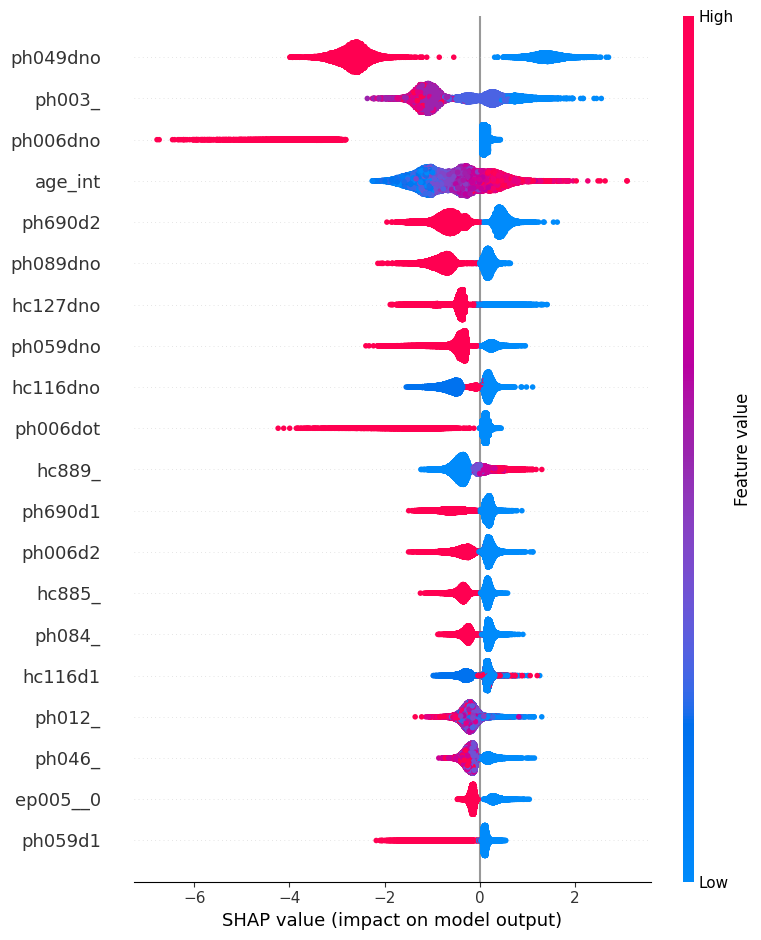

In [63]:
#shap.plots.beeswarm(shap_values, max_display=20)
shap.summary_plot(shap_values, X_train )

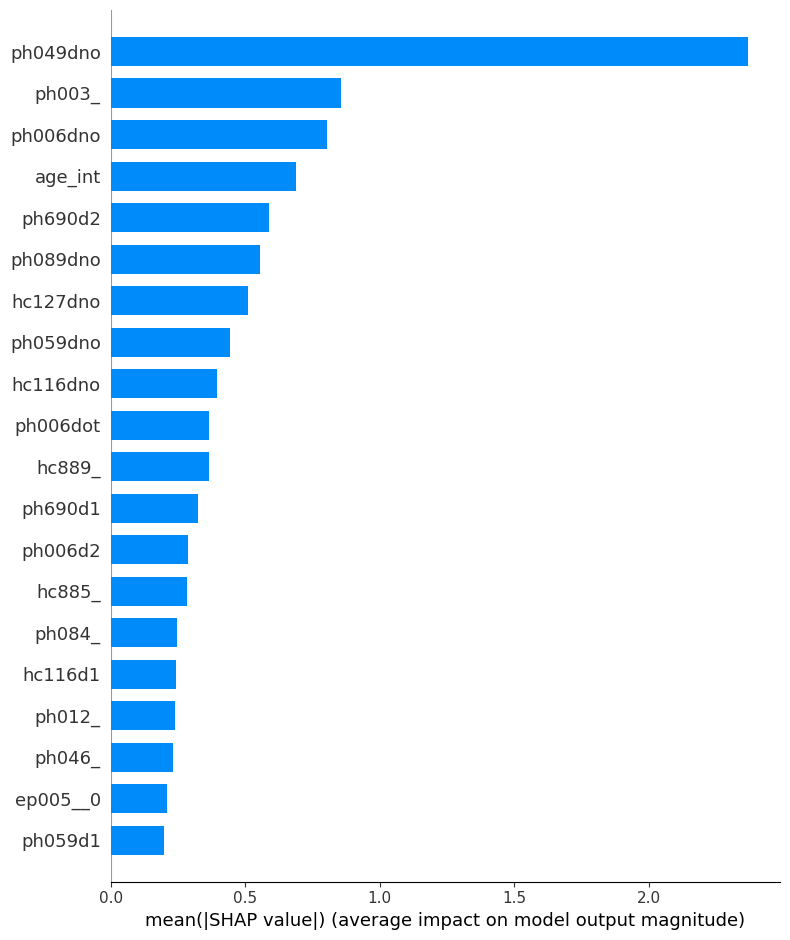

In [64]:
shap.summary_plot(shap_values, X_test,  plot_type="bar")

# Baseline Logistic regression model

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib


In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

logreg = LogisticRegression(solver='lbfgs', max_iter=3000 )
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [68]:

y_pred= logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores = logreg.predict_proba(X_test)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep)


Overall Results:
Accuracy: 97.56 %
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9079
           1       0.59      0.28      0.38       250

    accuracy                           0.98      9329
   macro avg       0.79      0.64      0.68      9329
weighted avg       0.97      0.98      0.97      9329



<Figure size 1000x800 with 0 Axes>

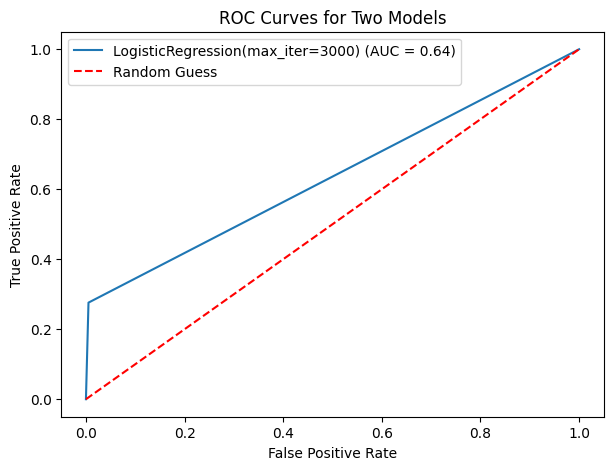

In [69]:
# Plot ROC curve for each model
auc = np.round(roc_auc_score(y_test, y_pred), 3)

plt.figure(figsize=(7, 5))

fpr, tpr, _ = roc_curve(y_test, y_pred)
#roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'{logreg} (AUC = {auc:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [70]:
from sklearn.metrics import brier_score_loss
probs = y_scores  [:, 1]
brier_score_loss(y_test, probs)

0.019553400840217044

In [71]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

cal_clf = CalibratedClassifierCV(logreg, method="sigmoid", cv="prefit")
cal_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv='prefit', estimator=LogisticRegression(max_iter=3000))

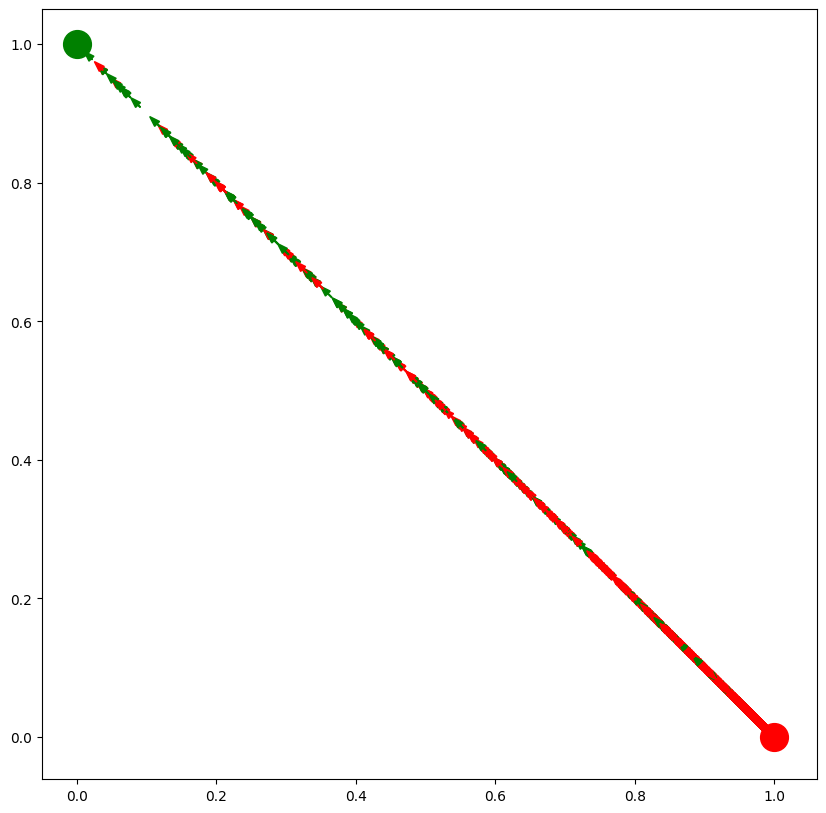

In [72]:
plt.figure(figsize=(10, 10))
#fig, ax = plt.subplots(figsize=(20, 10))
colors = ["r", "g", "b"]

clf_probs=y_scores
#clf_probs = clf.predict_proba(X_test)

cal_clf_probs = cal_clf.predict_proba(X_test)
# Plot arrows

# Plot arrows
for i in range(clf_probs.shape[0]):
    plt.arrow(
        clf_probs[i, 0],
        clf_probs[i, 1],
        cal_clf_probs[i, 0] - clf_probs[i, 0],
        cal_clf_probs[i, 1] - clf_probs[i, 1],
        color=colors[y_test.iloc[i]],
        head_width=1e-2,
    )

# Plot perfect predictions, at each vertex
plt.plot([1.0], [0.0], "ro", ms=20, label="Class 1")
plt.plot([0.0], [1.0], "go", ms=20, label="Class 2")


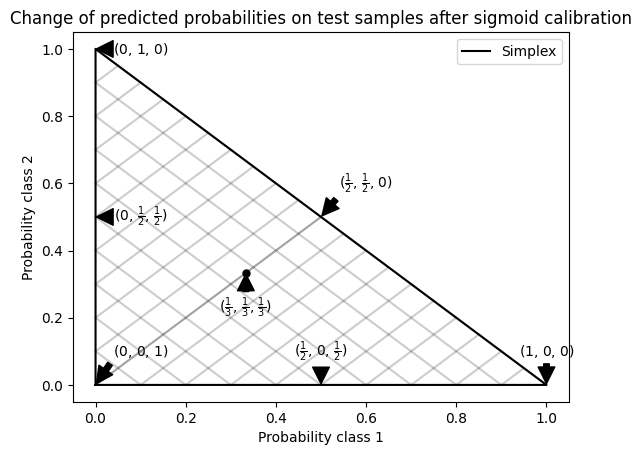

In [73]:

# Plot boundaries of unit simplex
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], "k", label="Simplex")

# Annotate points 6 points around the simplex, and mid point inside simplex
plt.annotate(
    r"($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)",
    xy=(1.0 / 3, 1.0 / 3),
    xytext=(1.0 / 3, 0.23),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.plot([1.0 / 3], [1.0 / 3], "ko", ms=5)
plt.annotate(
    r"($\frac{1}{2}$, $0$, $\frac{1}{2}$)",
    xy=(0.5, 0.0),
    xytext=(0.5, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $\frac{1}{2}$, $\frac{1}{2}$)",
    xy=(0.0, 0.5),
    xytext=(0.1, 0.5),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($\frac{1}{2}$, $\frac{1}{2}$, $0$)",
    xy=(0.5, 0.5),
    xytext=(0.6, 0.6),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $0$, $1$)",
    xy=(0, 0),
    xytext=(0.1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($1$, $0$, $0$)",
    xy=(1, 0),
    xytext=(1, 0.1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
plt.annotate(
    r"($0$, $1$, $0$)",
    xy=(0, 1),
    xytext=(0.1, 1),
    xycoords="data",
    arrowprops=dict(facecolor="black", shrink=0.05),
    horizontalalignment="center",
    verticalalignment="center",
)
# Add grid
plt.grid(False)
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], "k", alpha=0.2)
    plt.plot([0, 0 + (1 - x) / 2], [x, x + (1 - x) / 2], "k", alpha=0.2)
    plt.plot([x, x + (1 - x) / 2], [0, 0 + (1 - x) / 2], "k", alpha=0.2)

plt.title("Change of predicted probabilities on test samples after sigmoid calibration")
plt.xlabel("Probability class 1")
plt.ylabel("Probability class 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
_ = plt.legend(loc="best")

AUC-ROC (0): 0.64
Average AUC-ROC: 0.64


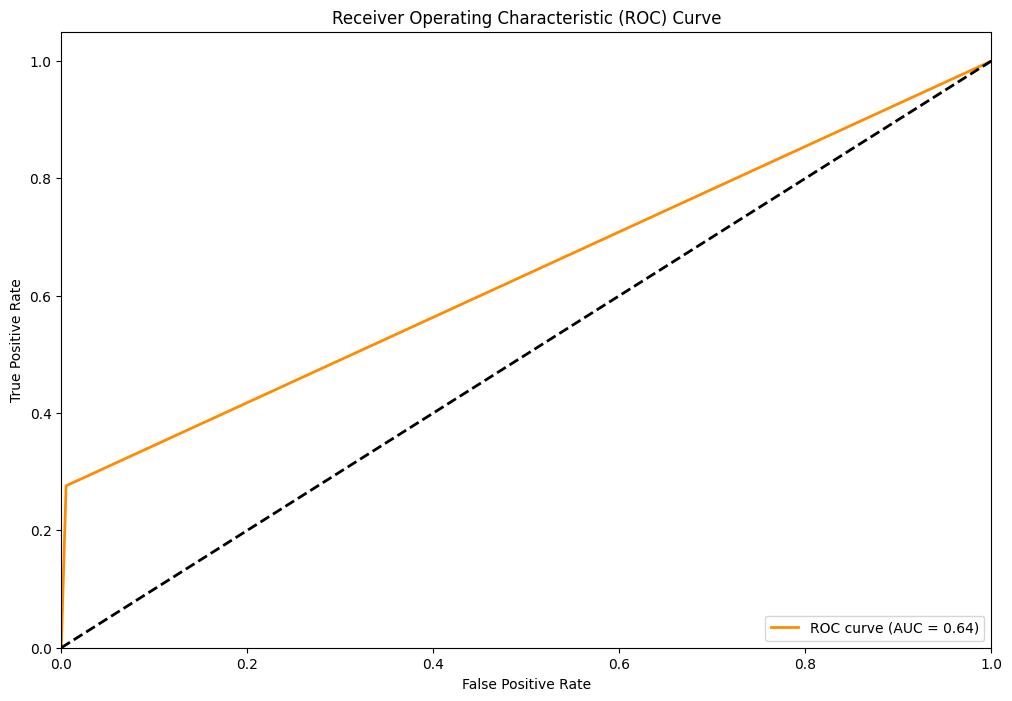

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming y_test and y_pred are defined earlier in your code

# Check if y_test needs binarization for binary classification
if len(np.unique(y_test)) == 2:
    # Binary classification
    n_classes = 2
    y_test_bin = label_binarize(y_test, classes=[0, 1])
    y_pred_bin = label_binarize(y_pred, classes=[0, 1])
else:
    # Multi-class classification
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_pred_bin = label_binarize(y_pred, classes=np.unique(y_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
auc_roc_scores = []

# Handling for binary classification scenario
if n_classes == 2:
    fpr[0], tpr[0], _ = roc_curve(y_test_bin, y_pred_bin)
    roc_auc[0] = auc(fpr[0], tpr[0])
    auc_roc_scores.append(roc_auc[0])
else:
    # Multi-class classification scenario
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_roc_scores.append(roc_auc[i])

# Print AUC-ROC scores
for i in roc_auc:
    print(f"AUC-ROC ({i}): {roc_auc[i]:.2f}")
print("Average AUC-ROC: {:.2f}".format(np.mean(auc_roc_scores)))

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
if n_classes == 2:
    plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc[0])
else:
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [79]:

y_pred_encoded = logreg.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate AUC-ROC for each column
auc_roc_scores = []

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

y_scores = logreg.predict_proba(X_test)

# Display overall results
print("\nOverall Results:")
print("Accuracy: {:.2f} %".format(accuracy * 100))
print("Classification Report:\n", classification_rep)


Overall Results:
Accuracy: 97.56 %
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      9079
           1       0.59      0.28      0.38       250

    accuracy                           0.98      9329
   macro avg       0.79      0.64      0.68      9329
weighted avg       0.97      0.98      0.97      9329



<Figure size 1000x800 with 0 Axes>

# Logistic Regression Model Report

**Model Configuration:**

The model was configured with a maximum iteration parameter of 3000 to ensure convergence.
It was fitted using the 'lbfgs' solver, a common choice for small and medium-sized datasets.

**Model Training:**

The model was trained on a split dataset with a test size of 20% and a specific random state for reproducibility.

**Model Performance Metrics:**

Accuracy: The model achieved a high overall accuracy of 97.56% on the test data.

Precision for Class 0: High at 0.98, indicating that the model is very effective at identifying true negatives.

Recall for Class 0: Also high at 0.99, showing the model is good at capturing all relevant instances of Class 0.

Precision for Class 1: Moderate at 0.59, suggesting that when the model predicts Class 1, it is correct 59% of the time.

Recall for Class 1: Lower at 0.28, indicating that the model identifies only 28% of all actual Class 1 instances.

F1-Score for Class 0: At 0.99, indicating excellent test
accuracy for Class 0.

F1-Score for Class 1: At 0.38, which is relatively low, reflecting the balance between precision and recall for Class 1.
**Model Evaluation:**

Brier Score: The Brier score for the positive class is 0.0196, which indicates that the predicted probabilities are well-calibrated.

ROC Curve and AUC: The AUC of 0.64 shows that the model has a modest ability to differentiate between the classes. It's better than random guessing but may not be sufficient for all applications, especially those that require high sensitivity and specificity.

**Model Interpretation:**

The model shows excellent predictive power for the majority class (Class 0) but is less effective for the minority class (Class 1).

The high accuracy is somewhat misleading due to the class imbalance, and the AUC provides a more nuanced view of the model's predictive ability across classes.

The modest AUC score relative to the high accuracy suggests that the model's high accuracy is primarily due to its performance on the majority class.

# The comparison is based on metrics such as accuracy, precision, recall, and F1-score. Comparison between XGBoost and baseline logistic regression model

**Overall Performance**

XGBoost appears to excel in handling complex patterns in the data, achieving an average accuracy of 0.84. This is indicative of its capability to model non-linear relationships effectively.
Logistic Regression, a linear model, shows commendable performance given its simplicity, with accuracies for individual outputs ranging from 0.4889 to 0.9819. This variance in performance can be attributed to its linear nature, which might not capture complex relationships as effectively as XGBoost.


**Precision, Recall, and F1-Score**

XGBoost demonstrates a balanced approach between precision and recall across most outputs, leading to relatively high F1-scores. This balance is crucial in applications where both the relevance of the result (precision) and the ability to identify all relevant instances (recall) are important.
Logistic Regression shows variability in its ability to balance precision and recall, as evidenced by its performance across different outputs. In some cases, it achieves high precision at the cost of recall, or vice versa, affecting its F1-scores.

**Specific Outputs**
For outputs like cf003_ and cf837_, both models show high accuracy, with XGBoost slightly outperforming Logistic Regression. This could be due to XGBoost's ability to better capture the underlying patterns.
Outputs dealing with nuanced classifications (cf103_, cf831_) reveal the strength of XGBoost in handling complex relationships, as Logistic Regression struggles to achieve competitive recall and F1-scores.
The performance on outputs with a high imbalance (mh004__7, mh004__Any mention of suicidal feelings or wish to be dead) showcases XGBoost's robustness, maintaining high accuracy and managing to achieve better recall rates compared to Logistic Regression.

**General Observation:**

Both models are applied to a multi-output classification task. Each output represents a different binary classification problem.

The models are evaluated based on precision, recall, f1-score, and accuracy.

**XGBoost Model:**

The XGBoost model tends to have high accuracy across all outputs, which is a strong point in favor of this model.
However, similar to the logistic regression, it struggles with class imbalance, particularly with minority classes.
The precision, recall, and F1 scores for minority classes are generally low, which indicates the model might be biased towards the majority class.
The model's high accuracy is likely due to the correct prediction of the majority class, which dominates the dataset.

**Baseline Logistic Regression Model:**

The logistic regression model shows varying levels of accuracy across different outputs, generally lower than XGBoost.
It also has issues with class imbalance, often failing to predict minority classes correctly.

Logistic regression seems to have a consistent problem with precision and recall for minority classes, indicating a high number of false positives and false negatives for these classes.

In some cases, logistic regression fails to predict any instances of the minority class correctly, which is problematic for sensitive applications.

**Comparative Analysis:**

Accuracy: XGBoost generally has higher accuracy than logistic regression across most outputs. However, this metric is less informative due to class imbalance.

Precision and Recall: Both models tend to favor the majority class, but XGBoost shows slightly better precision and recall for minority classes in some cases.

F1 Score: The weighted F1 score, which considers both precision and recall, is usually higher for the XGBoost model, suggesting it might be the better model overall for balancing the precision-recall trade-off.

Class Imbalance Handling: Neither model handles class imbalance well without additional techniques. Both models could benefit from class balancing strategies such as SMOTE, cost-sensitive learning, or custom class weights.

Sensitivity to Minority Classes: Given the nature of the target variables, especially those related to mental health, the inability of both models to accurately predict minority classes is a significant concern.

**Recommendations:**

Address the class imbalance problem with appropriate resampling techniques or by adjusting class weights in the model.

Evaluate models using more informative metrics for imbalanced classes, such as the F1 score, balanced accuracy, or area under the precision-recall curve (AUPRC).

Consider employing model evaluation techniques that can handle data imbalance effectively and provide a more accurate picture of model performance for minority classes.

Experiment with feature engineering and selection to improve model performance, especially for logistic regression.

For sensitive applications, special attention should be given to the models' recall for minority classes to reduce the risk of false negatives.

**Conclusion:**

While XGBoost shows a generally better performance profile than logistic regression, especially in terms of handling class imbalance, there is still significant room for improvement for both models. Careful consideration should be given to the choice of metrics and evaluation strategies, especially for applications where the cost of misclassification is high.

# FairLearn

In [81]:
!pip install fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.20.1 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.0 which is incompatible.


In [82]:
sensitive_feature_age = X_test['age_int']


In [83]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)


In [84]:
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

Metric by Group:
        accuracy
gender          
0       0.975174
1       0.976072


array([[<Axes: title={'center': 'accuracy'}, xlabel='gender'>,
        <Axes: xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>]], dtype=object)

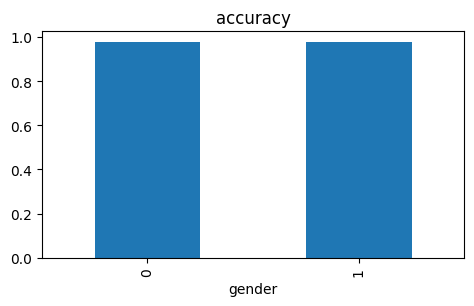

In [85]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
import matplotlib
# Define metrics that are applicable for multi-class
metrics = {
    'accuracy': accuracy_score,
    # Add any other multi-class supported metrics here
}

metric_frame = MetricFrame(metrics=metrics,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=X_test['gender'])

print("Metric by Group:")
print(metric_frame.by_group)

# If you want to visualize the disparities in metrics
metric_frame.by_group.plot(kind="bar", subplots=True, layout=(3, 2), figsize=(12, 10), legend=False)


In [86]:
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame

# Predictions from the logistic regression model
y_pred_logreg = logreg.predict(X_test)

# Calculate accuracy for each group defined by the sensitive attribute
metric_frame_logreg = MetricFrame(
    metrics=accuracy_score,
    y_true=y_test,
    y_pred=y_pred_logreg,
    sensitive_features=X_test['gender']
)

# Display fairness metrics
print(metric_frame_logreg.by_group)

# Calculate and print the difference in accuracy between groups for fairness assessment
# Calculate and print the difference in accuracy between groups for fairness assessment
accuracy_diff = metric_frame_logreg.difference()
print(f"Accuracy difference between groups: {accuracy_diff}")


gender
0    0.975174
1    0.976072
Name: accuracy_score, dtype: float64
Accuracy difference between groups: 0.0008978143620670398


# Comparison report of the three models — XGBoost, Logistic Regression, and the Kaplan-Meier/Cox Proportional Hazards model

# Suggest extensions like multi-modal frameworks


1. Integrated Multi-Modal Data Processing
Description: Develop pipelines that integrate and process multiple types of data simultaneously. This could involve combining textual descriptions with tabular data about individuals or incorporating image data alongside traditional structured data.
Application: In healthcare, patient data might include structured records, radiology images, and doctor's notes. A multi-modal approach could enhance predictive models for patient outcomes by integrating these varied data sources.

2. Multi-Modal Embeddings for Fairness
Description: Utilize embeddings from different modalities (text embeddings, image embeddings) and apply fairness constraints or regularization during the training process to ensure equitable performance across different groups.
Application: In job recommendation systems, resumes (text), candidate images, and structured application data can be processed together. Embeddings from each modality can be jointly learned to recommend candidates fairly across demographic groups.

3. Cross-Modal Fairness Adjustments
Description: Apply cross-modal adjustments where the model learns to mitigate bias by adjusting predictions from one modality based on fairness metrics observed in another modality.
Application: In sentiment analysis using customer feedback, textual data (reviews) and customer metadata (age, location) can be used together. The model can adjust biases in text interpretation based on fairness considerations in customer metadata.

4. Fairness in Multi-Modal Fusion
Description: Develop techniques for the fair fusion of multi-modal data, ensuring that the combination process does not introduce or amplify bias.
Application: In autonomous driving systems, sensor data (LiDAR, radar), images, and map data are fused to make driving decisions. Fair fusion ensures decisions are equitable across different environments and conditions (e.g., urban vs. rural).

# Kaplan-Meier/Cox Proportional Hazards Model:

**Kaplan-Meier Analysis:**

The Kaplan-Meier survival curves illustrate the survival probability over time for two cohorts: patients with at least one positive axillary node detected and those with no positive axillary nodes detected.

The survival probability declines over time, with the cohort having positive axillary nodes showing a faster decline, suggesting higher risk or poorer prognosis.

**Cox Proportional Hazards Analysis:**

The Cox model was fitted to the data with a focus on the effect of covariates on survival time.

Convergence was achieved after 62 iterations, indicating that the model found a stable solution for the coefficients.
The model includes right-censored observations, which are cases where the event of interest has not occurred before the end of the study period.

**Comparative Analysis Across All Three Models:**

**Model Applicability:**

XGBoost and Logistic Regression: Suitable for classification tasks with binary or multi-class outcomes.

Kaplan-Meier/Cox Proportional Hazards: Suitable for survival analysis where the outcome is time until an event occurs.

**Performance Metrics:**

**XGBoost:** AUC 0.65, Brier Score 0.0173, high accuracy but moderate discrimination between classes.

**Logistic Regression:** AUC 0.64, Brier Score 0.0196, high accuracy with similar discrimination as XGBoost.

**Kaplan-Meier/Cox**: Not comparable using AUC or Brier Score; instead, the focus is on survival probability and hazard ratios.

**Model Interpretation and Complexity:**

XGBoost: Complex with less interpretability, captures intricate data patterns.

Logistic Regression: Simpler and more interpretable, may not capture complex patterns as effectively.

Kaplan-Meier/Cox: Kaplan-Meier is straightforward in interpretation, Cox model is more complex due to regression on covariates.

